In [1]:
import h5py

filename_hdf = 'greenbeans.h5'

def h5_tree(val, pre=''):
    items = len(val)
    for key, val in val.items():
        items -= 1
        if items == 0:
            # the last item
            if type(val) == h5py._hl.group.Group:
                print(pre + '└── ' + key)
                h5_tree(val, pre+'    ')
            else:
                try:
                    print(pre + '└── ' + key + ' (%d)' % len(val))
                except TypeError:
                    print(pre + '└── ' + key + ' (scalar)')
        else:
            if type(val) == h5py._hl.group.Group:
                print(pre + '├── ' + key)
                h5_tree(val, pre+'│   ')
            else:
                try:
                    print(pre + '├── ' + key + ' (%d)' % len(val))
                except TypeError:
                    print(pre + '├── ' + key + ' (scalar)')

with h5py.File(filename_hdf, 'r') as hf:
    print(hf)
    h5_tree(hf)

<HDF5 file "greenbeans.h5" (mode r)>
├── algo
│   ├── key (scalar)
│   └── processor_config (scalar)
├── client_info (scalar)
├── generation (scalar)
├── lib_version (scalar)
├── server_info (scalar)
├── session
│   ├── calibrations
│   │   └── sensor_1
│   │       ├── data (scalar)
│   │       ├── provided (scalar)
│   │       └── temperature (scalar)
│   ├── group_0
│   │   └── entry_0
│   │       ├── metadata (scalar)
│   │       ├── result
│   │       │   ├── calibration_needed (65763)
│   │       │   ├── data_saturated (65763)
│   │       │   ├── frame (65763)
│   │       │   ├── frame_delayed (65763)
│   │       │   ├── temperature (65763)
│   │       │   └── tick (65763)
│   │       └── sensor_id (scalar)
│   └── session_config (scalar)
├── sessions
│   └── session_0
│       ├── calibrations
│       │   └── sensor_1
│       │       ├── data (scalar)
│       │       ├── provided (scalar)
│       │       └── temperature (scalar)
│       ├── group_0
│       │   └── entry_0
│       

In [2]:
import h5py
import numpy as np

def extract_tensor_from_h5(file_path, dataset_path):
    """
    Extracts a tensor from an H5 file and checks for non-numerical data.

    Parameters:
    - file_path: str, path to the H5 file
    - dataset_path: str, path to the dataset within the H5 file

    Returns:
    - tensor: numpy.ndarray, the extracted tensor if purely numerical
    """
    with h5py.File(file_path, 'r') as h5file:
        if dataset_path in h5file:
            dataset = h5file[dataset_path]
            tensor = np.array(dataset)

            return tensor
        else:
            raise KeyError(f"Dataset {dataset_path} not found in the file {file_path}")


# Example usage
file_path = 'greenbeans.h5'
dataset_path = 'session/group_0/entry_0/result/frame'
tensor = extract_tensor_from_h5(file_path, dataset_path)

# Print the shape of the tensor
print(tensor.shape)


(65763, 1, 64)


In [3]:
import numpy as np

def load_and_convert_tensor(file_path, dataset_path):
    # Extract tensor from HDF5 file
    tensor = extract_tensor_from_h5(file_path, dataset_path)

    # Convert to complex number
    complex_tensor = tensor['real'] + 1j * tensor['imag']

    return complex_tensor

# Load and convert tensors
greenbeans_tensor = load_and_convert_tensor("greenbeans.h5", dataset_path)
ethopianbeans458tensor = load_and_convert_tensor("458ethopianroast.h5", dataset_path)
roastedbeans458tensor = load_and_convert_tensor("458roastedbeans.h5", dataset_path)
roastedbeans658tensor = load_and_convert_tensor("658roastedbeans.h5", dataset_path)
roastedbeans958tensor = load_and_convert_tensor("958roastedbeans.h5", dataset_path)
roastedbeans1158tensor = load_and_convert_tensor("1158roastedbeans.h5", dataset_path)

def preprocess_data(complex_tensor):
    # Separate real and imaginary parts
    real_part = complex_tensor.real.astype(np.float32)
    imag_part = complex_tensor.imag.astype(np.float32)

    # Combine into a single input array (concatenation along the last axis)
    combined_input = np.concatenate([real_part, imag_part], axis=-1)

    return combined_input

# Process tensors
greenbeans_input = preprocess_data(greenbeans_tensor)
ethopianbeans458_input = preprocess_data(ethopianbeans458tensor)
roastedbeans458_input = preprocess_data(roastedbeans458tensor)
roastedbeans658_input = preprocess_data(roastedbeans658tensor)
roastedbeans958_input = preprocess_data(roastedbeans958tensor)
roastedbeans1158_input = preprocess_data(roastedbeans1158tensor)

In [5]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Flatten, Input
from sklearn.model_selection import train_test_split

# Create labels
greenbeans_labels = np.zeros(greenbeans_input.shape[0], dtype=np.int32)  # Class 0
ethopianbeans458_labels = np.ones(ethopianbeans458_input.shape[0], dtype=np.int32) # Class 1
roastedbeans458_labels = np.full(roastedbeans458_input.shape[0], 2, dtype=np.int32)  # Class 2
roastedbeans658_labels = np.full(roastedbeans658_input.shape[0], 3, dtype=np.int32) # Class 3
roastedbeans958_labels = np.full(roastedbeans958_input.shape[0], 4, dtype=np.int32) # Class 4
roastedbeans1158_labels = np.full(roastedbeans1158_input.shape[0], 5, dtype=np.int32)  # Class 5

def squeeze_data(data):
    # Remove dimensions of size 1
    return np.squeeze(data, axis=1)

# Apply squeezing to each tensor
greenbeans_input = squeeze_data(greenbeans_input)
ethopianbeans458_input = squeeze_data(ethopianbeans458_input)
roastedbeans458_input = squeeze_data(roastedbeans458_input)
roastedbeans658_input = squeeze_data(roastedbeans658_input)
roastedbeans958_input = squeeze_data(roastedbeans958_input)
roastedbeans1158_input = squeeze_data(roastedbeans1158_input)

# Combine the squeezed data
all_inputs = np.concatenate([greenbeans_input, ethopianbeans458_input, roastedbeans458_input, roastedbeans658_input, roastedbeans958_input, roastedbeans1158_input], axis=0)
all_labels = np.concatenate([greenbeans_labels, ethopianbeans458_labels, roastedbeans458_labels, roastedbeans658_labels, roastedbeans958_labels, roastedbeans1158_labels], axis=0)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(all_inputs, all_labels, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")

# Define the Keras model
input_shape = (64 * 2,)  # Assuming real and imaginary parts are concatenated
model = Sequential([
    Input(shape=input_shape),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(64, activation='relu'),
    Dense(6, activation='softmax')  # don't forget to change this to the number of classes
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=128, validation_data=(X_test, y_test))

Training data shape: (372812, 128)
Testing data shape: (93204, 128)


I0000 00:00:1722979997.915058   52892 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1722979997.947992   52892 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1722979997.948056   52892 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1722979997.950790   52892 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1722979997.950866   52892 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

Epoch 1/10


I0000 00:00:1722979999.721609   53443 service.cc:146] XLA service 0x7f1a8800ab20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1722979999.721689   53443 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 SUPER, Compute Capability 8.9
2024-08-06 14:33:19.745985: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-08-06 14:33:19.892292: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


  68/2913 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.5401 - loss: 1030.1429  

I0000 00:00:1722980005.008887   53443 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2913/2913 ━━━━━━━━━━━━━━━━━━━━ 22s 5ms/step - accuracy: 0.8835 - loss: 59.6091 - val_accuracy: 0.9167 - val_loss: 2.1246
Epoch 2/10
2913/2913 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9343 - loss: 0.9446 - val_accuracy: 0.8820 - val_loss: 1.5364
Epoch 3/10
2913/2913 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.9307 - loss: 0.4439 - val_accuracy: 0.9348 - val_loss: 0.2427
Epoch 4/10
2913/2913 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.9380 - loss: 0.2016 - val_accuracy: 0.9361 - val_loss: 0.2125
Epoch 5/10
2913/2913 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.9442 - loss: 0.1636 - val_accuracy: 0.9242 - val_loss: 0.2425
Epoch 6/10
2913/2913 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9471 - loss: 0.1557 - val_accuracy: 0.9594 - val_loss: 0.1133
Epoch 7/10
2913/2913 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9490 - loss: 0.1507 - val_accuracy: 0.9586 - val_loss: 0.1167
Epoch 8/10
2913/2913 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9551 - loss: 0.1279 - val_a

2913/2913 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step


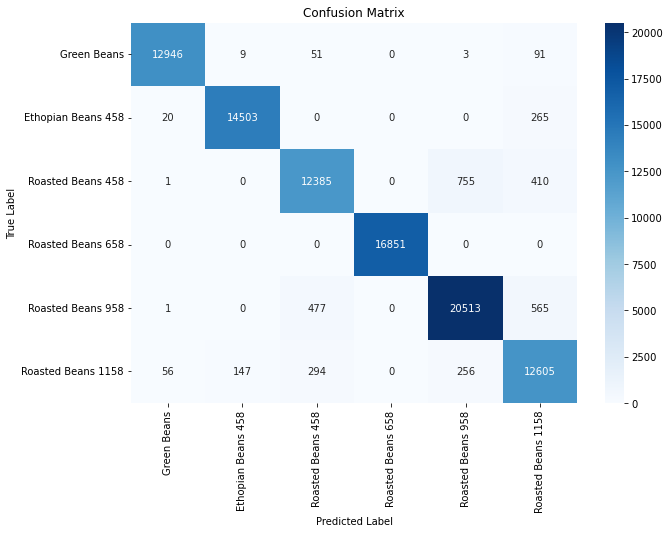

In [6]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Make predictions on the test set
y_pred = np.argmax(model.predict(X_test), axis=-1)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

# Define class names based on your dataset
class_names = ['Green Beans', 'Ethopian Beans 458', 'Roasted Beans 458', 'Roasted Beans 658', 'Roasted Beans 958', 'Roasted Beans 1158']

# Plot confusion matrix
plot_confusion_matrix(cm, class_names)

In [7]:
model.save("classifier_coffee_2.keras")

In [ ]:
# import numpy as np
# import tensorflow as tf
# from keras.models import load_model

# # Define preprocessing functions
# def preprocess_data(complex_tensor):
#     real_part = complex_tensor.real.astype(np.float32)
#     imag_part = complex_tensor.imag.astype(np.float32)
#     combined_input = np.concatenate([real_part, imag_part], axis=-1)
#     return combined_input

# def load_and_convert_tensor(file_path, dataset_path):
#     tensor = extract_tensor_from_h5(file_path, dataset_path)
#     complex_tensor = tensor['real'] + 1j * tensor['imag']
#     return complex_tensor

# def reshape_data(data):
#     return data.reshape(data.shape[0], -1)

# # Load and preprocess new data
# new_data_tensor = load_and_convert_tensor("test.h5", dataset_path)
# new_data_input = preprocess_data(new_data_tensor)
# new_data_input = reshape_data(new_data_input)

# # Load the saved model
# model = load_model('model.h5')
# print("Model loaded from 'model.h5'")

# # Make predictions
# predictions = model.predict(new_data_input)
# predicted_classes = np.argmax(predictions, axis=-1)

# # Print predictions
# print("Predicted classes:", predicted_classes)


FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = 'test.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)